In [1]:
import SITSpinOneMFT as sit
import numpy as np 
from scipy import integrate as intg
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as mclr


In [112]:
Lx = 10
Ly = 10
Ej = 1.
Ec = sit.rng.uniform(low=2.*Ej,high=2.*Ej,size=(Lx,Ly))
wf,e = sit.find_GS(Lx,Ly,Ec,Ej,wf0=sit.initialize_SF(Lx,Ly,0.))

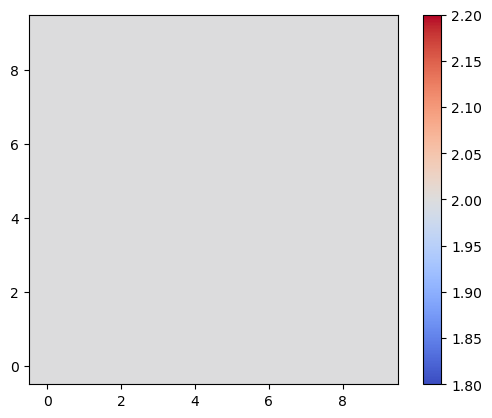

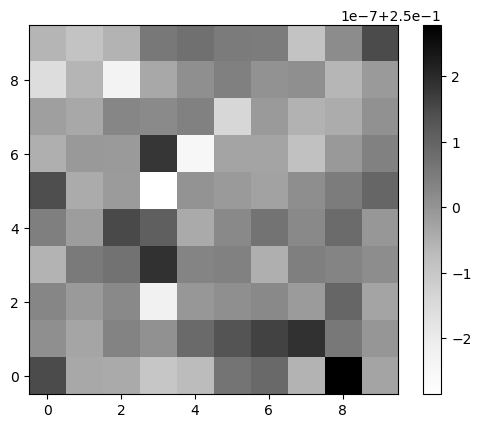

In [113]:
plt.imshow(Ec,origin='lower',cmap='coolwarm')
plt.colorbar()
plt.show()

plt.imshow(sit.charge_squared(wf),origin='lower',cmap='Greys')
plt.colorbar()
plt.show()

In [114]:
nts = 200
times = np.linspace(0.,20.,nts)

In [115]:
fluxes = [1.4,-1.4]
tR = 5.

qfs = [ lambda t: sit.ramsey_flux_quench(t,flux,tR) for flux in fluxes ]

In [116]:
wf_vs_ts = [ sit.solve_eom_quench(Lx,Ly,Ec,Ej,times,qf,wf) for qf in qfs ]

In [117]:
m_vs_ts = [ sit.magnetization(wf_vs_t) for wf_vs_t in wf_vs_ts ]
c2_vs_ts = [ sit.charge_squared(wf_vs_t) for wf_vs_t in wf_vs_ts ]

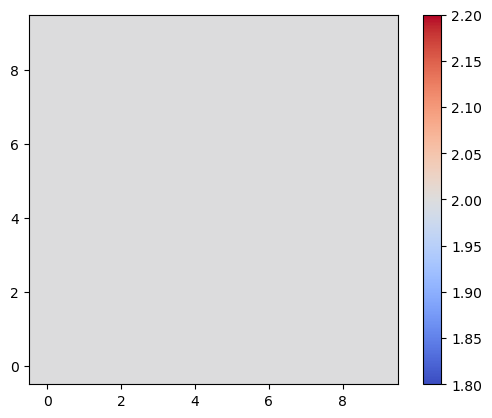

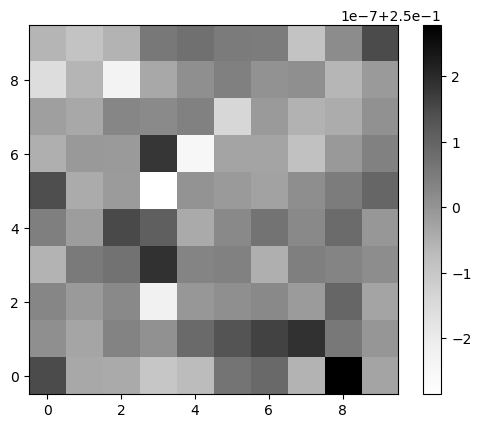

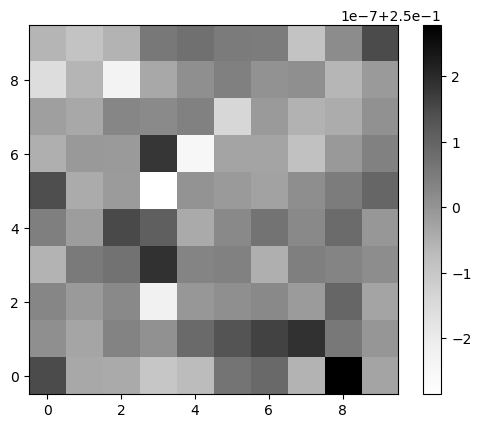

In [118]:
plt.imshow(Ec,origin='lower',cmap='coolwarm')
plt.colorbar()
plt.show()

for wf_vs_t in wf_vs_ts:
    plt.imshow(sit.charge_squared(wf_vs_t[:,:,:,0]),origin='lower',cmap='Greys')
    plt.colorbar()
    plt.show()


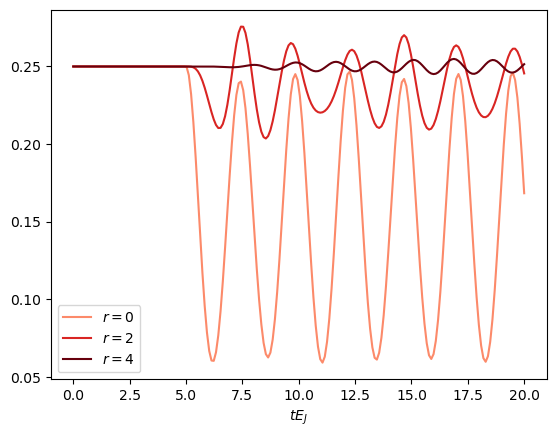

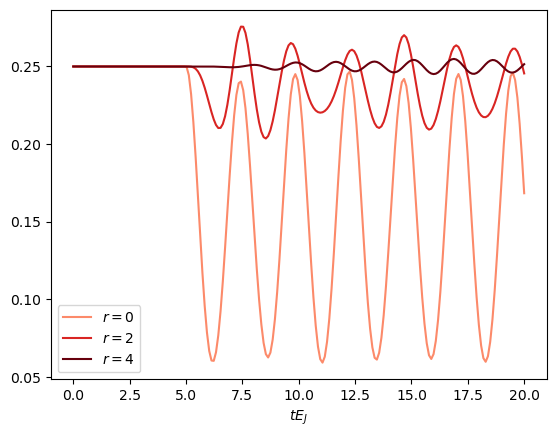

In [119]:
sites = [0,2,4]
clrs = cm.Reds(np.linspace(0.4,1.,len(sites)))
for c2_vs_t in c2_vs_ts:
    for i in range(len(sites)):
        plt.plot(times,c2_vs_t[sites[i],0,:],label=r'$r=$'+str(sites[i]),color=clrs[i])
    plt.xlabel(r'$tE_J$')
    plt.legend()
    plt.show()

In [120]:
Loschmidt_echo = np.array([ np.prod(sit.overlap(wf_vs_ts[0][...,0],wf_vs_ts[1][...,t])) for t in range(len(times)) ])

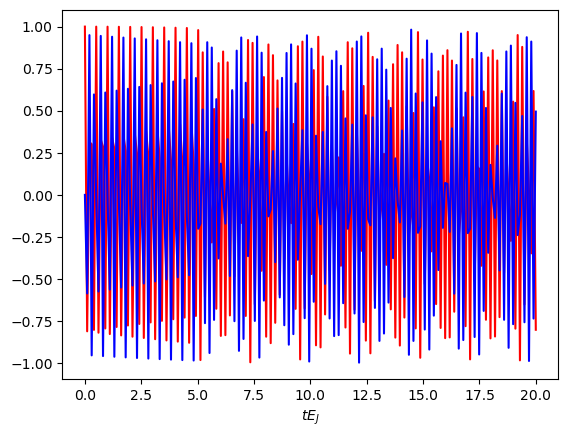

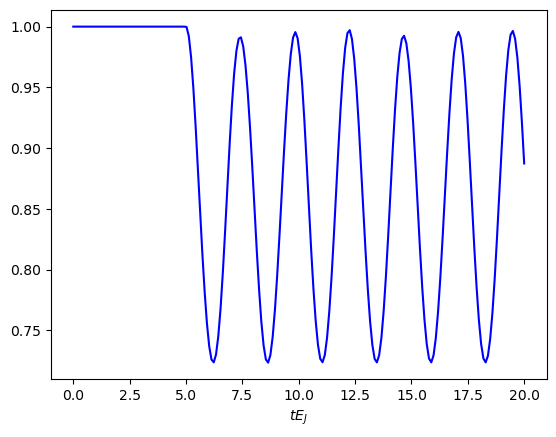

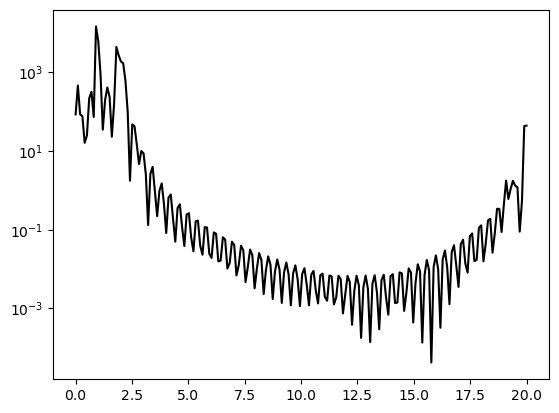

In [121]:
plt.plot(times,np.real(Loschmidt_echo),color='red')
plt.plot(times,np.imag(Loschmidt_echo),color='blue')
plt.xlabel(r'$tE_J$')
plt.show()

plt.plot(times,np.abs(Loschmidt_echo)**2,color='blue')
plt.xlabel(r'$tE_J$')
plt.show()

plt.plot(times,np.abs(np.fft.fftshift(np.fft.fft(Loschmidt_echo)))**2,color='black')
plt.yscale('log')
plt.show()




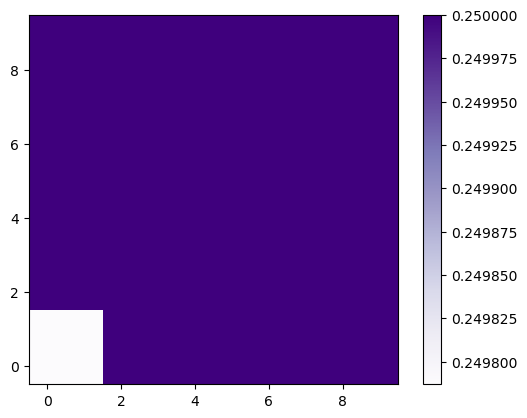

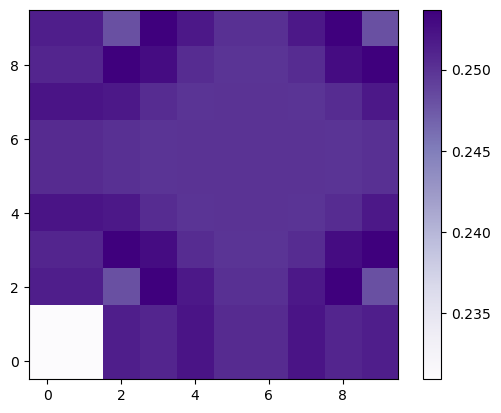

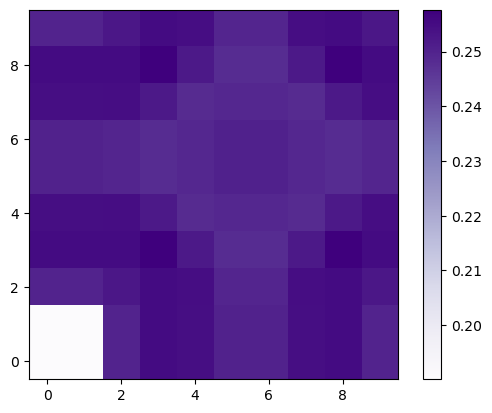

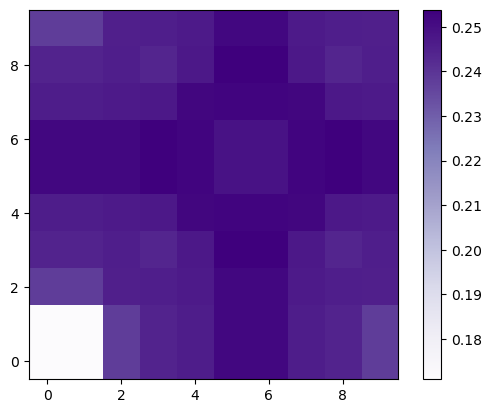

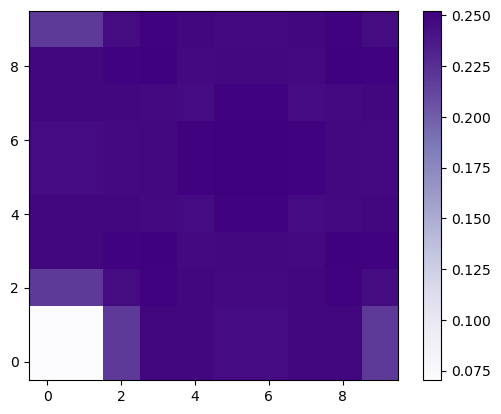

In [125]:
ts = [50,100,150,175,180]
for i in ts:
    plt.imshow(c2_vs_t[:,:,i],origin='lower',cmap='Purples')
    plt.colorbar()
    plt.show()
